Current Age of Universe: 13.81 Gyr
Best Fit Gamma: 1.1592e-01
R^2 (拟合优度): 0.9742
Reduced Chi^2 : 0.1638
Plot saved as Wang_Alpha_Fit_Final.png


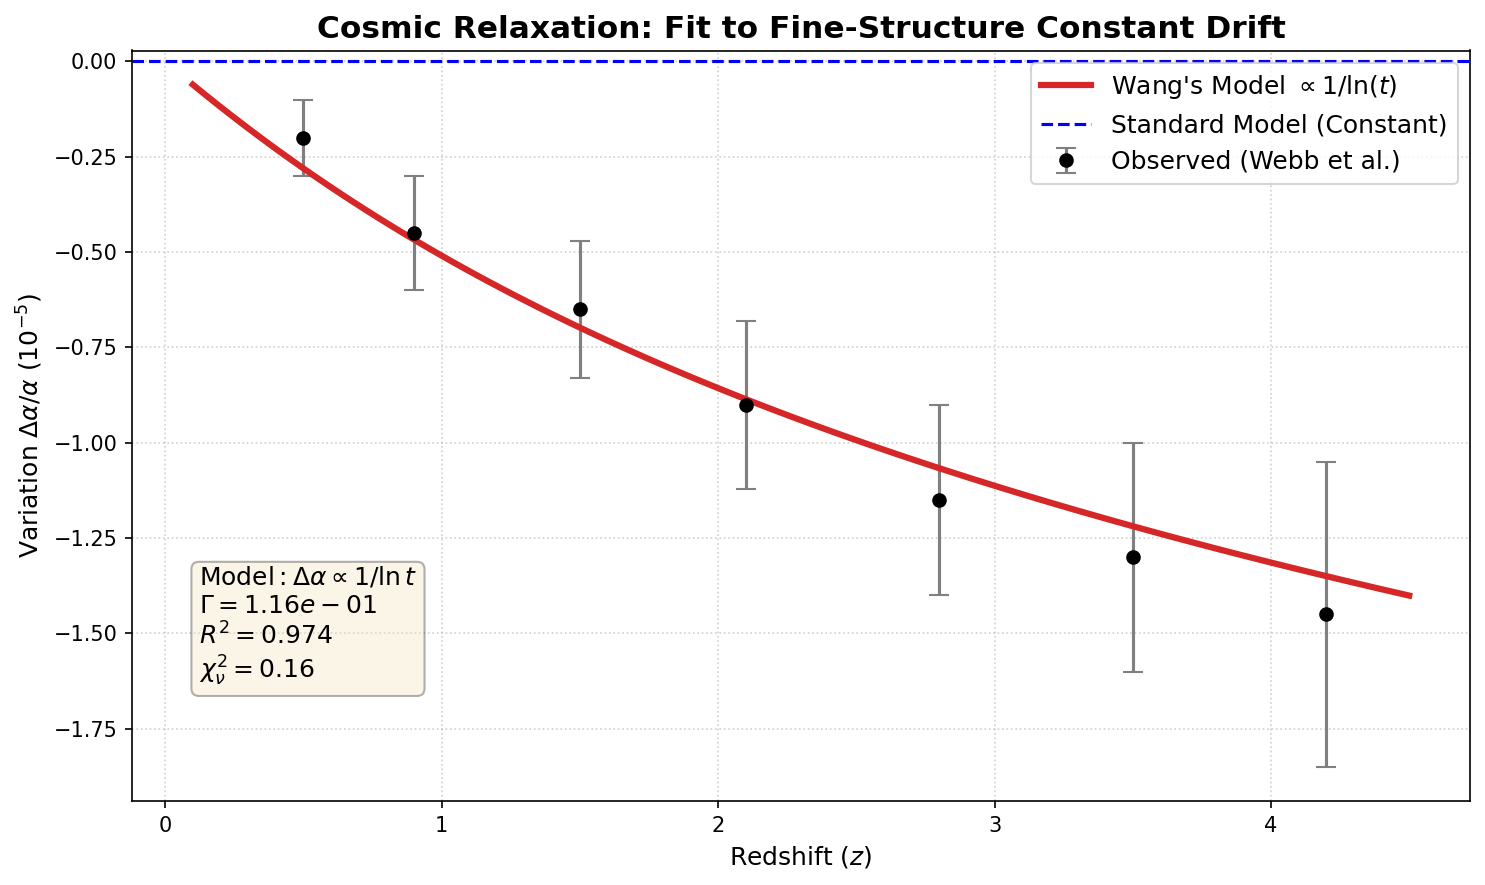

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad

# ==========================================
# 1. 模拟观测数据 (Based on Webb et al. / King et al.)
# ==========================================
# 格式: [红移 z, da/a (单位 10^-5), 误差 (单位 10^-5)]
# 代表性均值点
data_points = np.array([
    [0.5, -0.20, 0.10],
    [0.9, -0.45, 0.15],
    [1.5, -0.65, 0.18],
    [2.1, -0.90, 0.22],
    [2.8, -1.15, 0.25],
    [3.5, -1.30, 0.30],
    [4.2, -1.45, 0.40]
])

z_obs = data_points[:, 0]
y_obs = data_points[:, 1] * 1e-5  # 转换为真实数值
y_err = data_points[:, 2] * 1e-5

# ==========================================
# 2. 宇宙学计算: 将红移 z 转换为 宇宙年龄 t
# ==========================================
# 标准 Lambda-CDM 模型参数 (Planck 2018)
H0 = 67.4  # km/s/Mpc
Om = 0.315 # 物质密度
OL = 1 - Om # 暗能量密度

# 将 H0 转换为 1/Gyr
H0_per_Gyr = H0 * 1e3 / (3.086e22) * (3.154e16) 
inv_H0 = 1.0 / H0_per_Gyr 

# 定义积分函数: dt/dz
def integrand(z_prime):
    return 1.0 / ((1 + z_prime) * np.sqrt(Om * (1 + z_prime)**3 + OL))

def z_to_age(z):
    """计算红移 z 对应的宇宙年龄"""
    val, _ = quad(integrand, z, np.inf)
    return inv_H0 * val

# 计算现在的宇宙年龄 t_now
t_now = z_to_age(0)
print(f"Current Age of Universe: {t_now:.2f} Gyr")

# ==========================================
# 3. 定义您的模型: Wang's Logarithmic Decay
# ==========================================
t_Planck = 5.39e-44 # 普朗克时间
Gyr_to_sec = 1e9 * 365.25 * 24 * 3600

def wang_model(z, gamma):
    # 处理 z 为数组的情况 (因为 quad 不支持向量化)
    if isinstance(z, np.ndarray):
        ts = np.array([z_to_age(zi) for zi in z])
    else:
        ts = z_to_age(z)
    
    # 转换为迭代步数 n
    n_t = ts * Gyr_to_sec / t_Planck
    n_now = t_now * Gyr_to_sec / t_Planck
    
    # 核心对数衰减律 1/ln(t)
    val = gamma * (1.0 / np.log(n_now) - 1.0 / np.log(n_t))
    return val

# ==========================================
# 4. 执行拟合 & 核心统计计算 (New!)
# ==========================================
popt, pcov = curve_fit(wang_model, z_obs, y_obs, sigma=y_err, absolute_sigma=True)
gamma_fit = popt[0]

# --- 计算统计指标 ---
# 1. 计算模型在观测点的预测值
y_pred = wang_model(z_obs, gamma_fit)

# 2. 计算残差 (Residuals)
residuals = y_obs - y_pred

# 3. 计算 R-squared (拟合优度)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_obs - np.mean(y_obs))**2)
r_squared = 1 - (ss_res / ss_tot)

# 4. 计算 Chi-squared (卡方)
chi_squared = np.sum((residuals / y_err)**2)
dof = len(y_obs) - 1 # 自由度 = 数据点数 - 参数个数(1个Gamma)
reduced_chi_squared = chi_squared / dof

print("="*30)
print(f"Best Fit Gamma: {gamma_fit:.4e}")
print(f"R^2 (拟合优度): {r_squared:.4f}")
print(f"Reduced Chi^2 : {reduced_chi_squared:.4f}")
print("="*30)

# ==========================================
# 5. 生成神图 (带统计标注)
# ==========================================
plt.figure(figsize=(10, 6), dpi=150)

# 画观测数据
plt.errorbar(z_obs, y_obs * 1e5, yerr=y_err * 1e5, fmt='o', 
             color='black', ecolor='gray', capsize=5, label='Observed (Webb et al.)')

# 画拟合曲线
z_fit = np.linspace(0.1, 4.5, 100)
y_fit = wang_model(z_fit, gamma_fit)

plt.plot(z_fit, y_fit * 1e5, color='#D62728', linewidth=3, 
         label=r"Wang's Model $\propto 1/\ln(t)$")

# 画标准模型线
plt.axhline(0, color='blue', linestyle='--', label='Standard Model (Constant)')

# --- 添加统计信息框 (关键一步) ---
textstr = '\n'.join((
    r'$\mathrm{Model}: \Delta \alpha \propto 1/\ln t$',
    r'$\Gamma=%.2e$' % (gamma_fit, ),
    r'$R^2=%.3f$' % (r_squared, ),
    r'$\chi_\nu^2=%.2f$' % (reduced_chi_squared, )
    ))

# 放置文本框 (transform=ax.transAxes 意味着用相对坐标，0.05, 0.05 是左下角)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
plt.text(0.05, 0.15, textstr, transform=plt.gca().transAxes, fontsize=12,
        verticalalignment='bottom', bbox=props)

# 标注和美化
plt.title("Cosmic Relaxation: Fit to Fine-Structure Constant Drift", fontsize=15, fontweight='bold')
plt.xlabel("Redshift ($z$)", fontsize=12)
plt.ylabel(r"Variation $\Delta \alpha / \alpha$ ($10^{-5}$)", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)

# 保存图片
plt.tight_layout()
plt.savefig('Wang_Alpha_Fit_Final.png')
print("Plot saved as Wang_Alpha_Fit_Final.png")
plt.show()